In [1]:
!pip install Bio

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 281.0/281.0 kB 5.8 MB/s eta 0:00:00a 0:00:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.2/3.2 MB 45.5 MB/s eta 0:00:00a 0:00:01


In [2]:
!pip install biopython

In [3]:
import Bio.PDB as pdb
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# ПОДГОТОВКА

Перейдите на <a href="https://projectswhynot.site/pdb-filtering/">эту страничку</a>, получим ID белков для этого семинара.

In [4]:
path = '/kaggle/input/ourdata/filtering_results.csv'

data = pd.read_csv(path, sep=';')

In [5]:
data

,pdb_id,model_id,chain_id
0,7BQR,17,A
1,6AMW,3,A
2,2K06,16,A
3,2K7H,5,A
4,2DLG,8,A
...,...,...,...
195,1DRO,12,A
196,2GSB,12,A
197,2KG2,19,A
198,2L6P,9,A


In [6]:
chains = []

In [7]:
parser = pdb.PDBParser()
for i in range(data.shape[0]):
    pdb_id, model_id, _ = data.loc[i]
    # качаем файл
    path = pdb.PDBList().retrieve_pdb_file(pdb_id,
                                           file_format="pdb")
    # открываем структуру
    struct = parser.get_structure(pdb_id, path)

    chain = struct[model_id].child_list[0].child_list
    chains += [chain]

Structure exists: '/kaggle/working/cs/pdb2csk.ent' 
Structure exists: '/kaggle/working/l3/pdb2l3f.ent' 
Structure exists: '/kaggle/working/a4/pdb6a4c.ent' 
Structure exists: '/kaggle/working/kj/pdb2kj9.ent' 
Structure exists: '/kaggle/working/ix/pdb1ixd.ent' 
Structure exists: '/kaggle/working/da/pdb2daw.ent' 
Structure exists: '/kaggle/working/k3/pdb2k3f.ent' 
Structure exists: '/kaggle/working/iy/pdb1iyy.ent' 
Structure exists: '/kaggle/working/l1/pdb1l1p.ent' 
Structure exists: '/kaggle/working/j0/pdb1j0s.ent' 
Structure exists: '/kaggle/working/lm/pdb1lmz.ent' 
Structure exists: '/kaggle/working/h2/pdb2h2m.ent' 
Structure exists: '/kaggle/working/dm/pdb2dmm.ent' 
Structure exists: '/kaggle/working/kx/pdb2kxr.ent' 
Structure exists: '/kaggle/working/bu/pdb7bul.ent' 
Structure exists: '/kaggle/working/e3/pdb2e34.ent' 
Structure exists: '/kaggle/working/ee/pdb2eea.ent' 
Structure exists: '/kaggle/working/kd/pdb2kdw.ent' 
Structure exists: '/kaggle/working/jf/pdb1jfj.ent' 
Structure ex

In [8]:
len(chains)

200

# ЧАСТЬ 1

### Задание 1. Соберите и выведите на гистограмме значения угла $\omega = \angle(C_\alpha^{i-1}, C^{i-1}, N^{i}, C_\alpha^{i})$. Почему он не рассматривается при предсказании геометрии?

In [9]:
omegas = []

for chain in chains:
    for i in range(1, len(chain)):
        try:
          ca_prev = chain[i - 1]["CA"].get_vector()
          c_prev = chain[i - 1]["C"].get_vector()
          n = chain[i]['N'].get_vector()
          ca = chain[i]['CA'].get_vector()

          omega = pdb.calc_dihedral(ca_prev, c_prev, n, ca)
          omegas.append(omega)
        except KeyError:
            continue



In [10]:
len(omegas)

27233

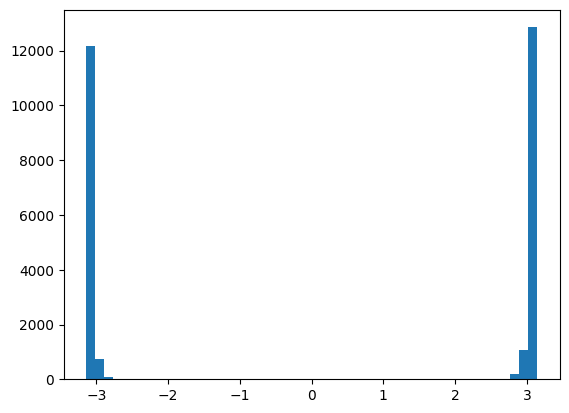

In [11]:
plt.hist(omegas, bins=50)
plt.show()

### Задание 2. Выведите отдельно гистограммы значений углов $\phi, \psi$.

In [12]:
phis = []
psis = []

for chain in chains:
  for i in range(1, len(chain) - 1):
    c_prev = chain[i - 1]["C"].get_vector()
    n = chain[i]['N'].get_vector()
    ca = chain[i]['CA'].get_vector()
    c = chain[i]['C'].get_vector()
    n_next = chain[i + 1]['N'].get_vector()

    phi = pdb.calc_dihedral(c_prev, n, ca, c) / np.pi * 180
    psi = pdb.calc_dihedral(n, ca, c, n_next) / np.pi * 180

    phis.append(phi)
    psis.append(psi)


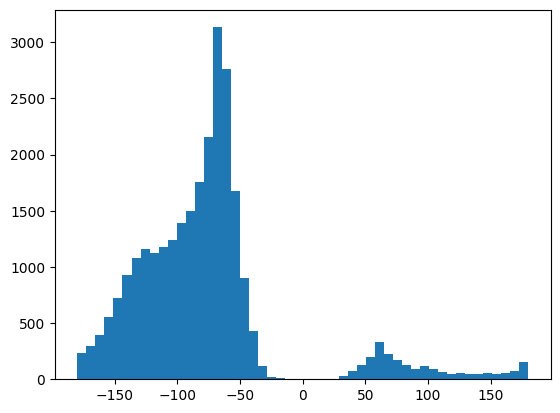

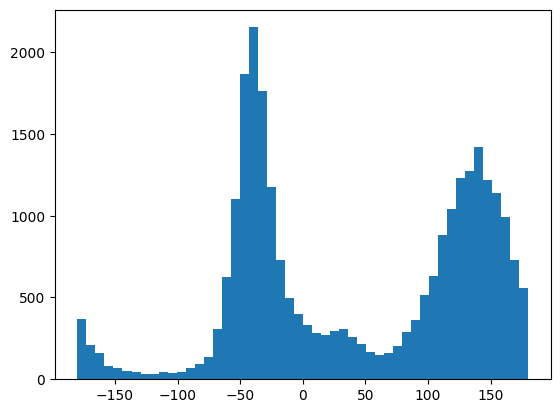

In [13]:
plt.hist(phis, bins=50)
plt.show()

plt.hist(psis, bins=50)
plt.show()

### Задание 3. Постройте карту Рамачандрана для собранных значений. Соотносится ли она с тем, что было рассказано на лекции?

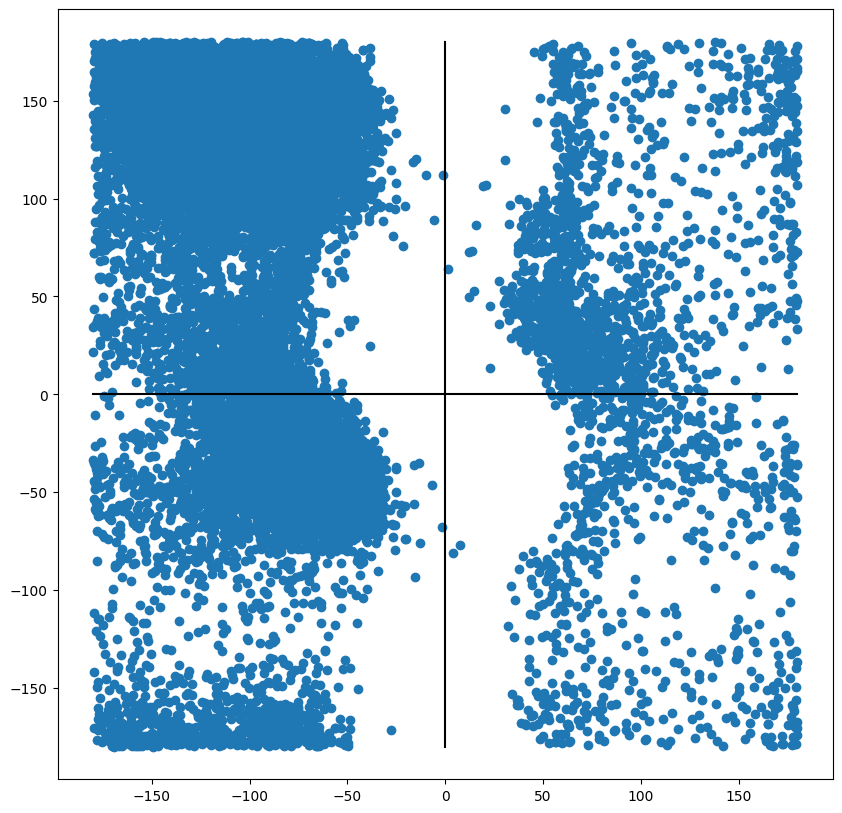

In [14]:
plt.figure(figsize=(10,10))


plt.plot([-180, 180], [0,0], c="black")
plt.plot([0,0], [-180, 180], c="black")

plt.scatter(phis, psis)

plt.axis("equal")
plt.show()

# ЧАСТЬ 2

### Допустим, у нас есть основной каркас (все атомы $N,C_\alpha, C$). Давайте восстановим координаты атома $C_\beta$. Для этого нам нужно значение двугранного угла $\angle(C^{i-1}, N^{i}, C_\alpha^{i}, C_\beta^{i})$, значение планарного угла $\angle(N^{i}, C_\alpha^{i}, C_\beta^{i})$ и длина связи $C_\alpha-C_\beta$.

### Задание 4.1. Соберите и выведите на гистограмме значения двугранного угла $\angle(C^{i-1}, N^{i}, C_\alpha^{i}, C_\beta^{i})$. Можно ли визуально заметить зависимость с углами $\phi, \psi?$

**Комментарий:** обратите внимание, у GLY нет атома $C_\beta$!

In [15]:
angles = []
phis = []

for chain in chains:
    for i in range(1, len(chain)):

        # ПОДСКАЗКА: зачем try-except? 😉
        try:

          c_prev = chain[i - 1]["C"].get_vector()
          n = chain[i]['N'].get_vector()
          ca = chain[i]['CA'].get_vector()
          cb = chain[i]['CB'].get_vector()
          c = chain[i]['C'].get_vector()

          phi = pdb.calc_dihedral(c_prev, n, ca, c) / np.pi * 180
          ang = pdb.calc_dihedral(c_prev, n, ca, cb) / np.pi * 180
          angles.append(ang)
          phis.append(phi)
        except KeyError:
            continue


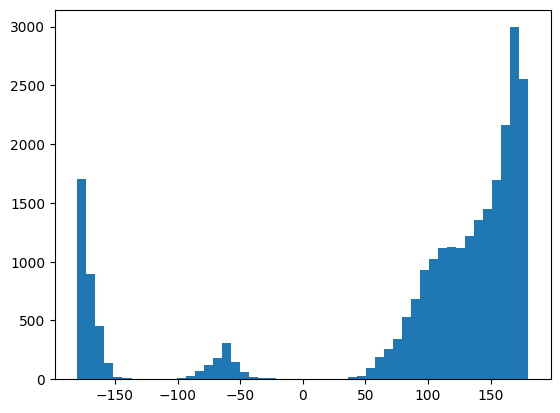

In [16]:
plt.hist(angles, bins=50)
plt.show()

In [17]:
phis = np.array(phis)
phis[phis < 0] += 360

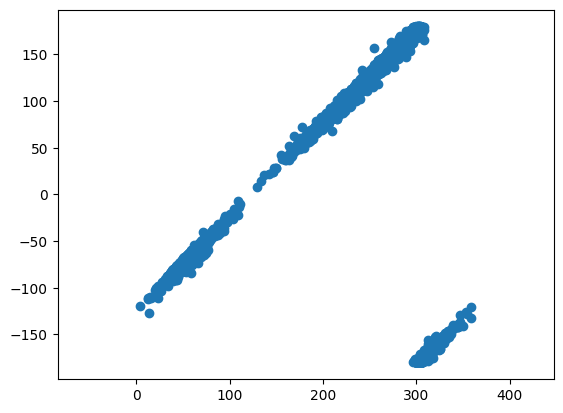

In [18]:
plt.scatter(phis, angles)
plt.axis('equal')
plt.show()

### Выведите на одном графике значения $\phi$ и $\angle(C^{i-1}, N^{i}, C_\alpha^{i}, C_\beta^{i})$. Восстановите зависимость любым способом.

**Комментарий**: восстановить зависимость = сделать функцию вида **ang_value(phi_value)**!

In [19]:
def ang_value(phi_value):
    if phi_value < -55:
      return phi_value + 235
    else:
      return phi_value - 125

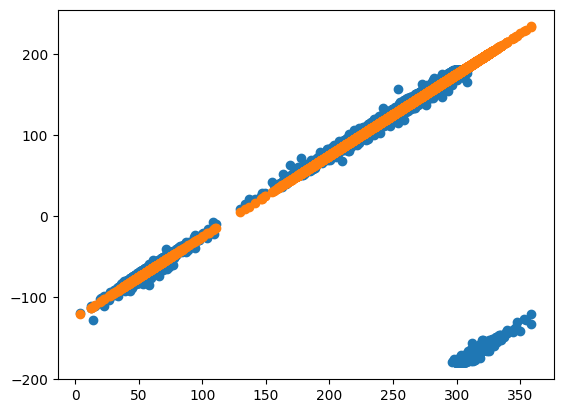

In [20]:
plt.scatter(phis, angles)
plt.scatter(phis, list(map(ang_value, phis)))

plt.show()

### Задание 4.2. Соберите и выведите на гистограмме значения планарного угла $\angle(N^{i}, C_\alpha^{i}, C_\beta^{i})$. Нужно ли здесь искать зависимость с другими углами или можно просто выбрать какое-то одно значение?

In [21]:
planar_angls = []

for chain in chains:
  for i in range(1, len(chain)):
    if chain[i].resname == 'GLY':
      continue
    n = chain[i]['N'].get_vector()
    ca = chain[i]['CA'].get_vector()
    cb = chain[i]['CB'].get_vector()

    pl_ang = pdb.calc_angle(n, ca, cb) / np.pi * 180

    planar_angls.append(pl_ang)

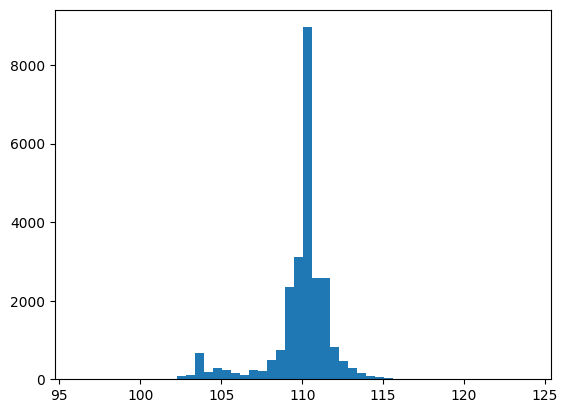

In [22]:
plt.hist(planar_angls, bins = 50)
None

## Видно что распределение планарных углов концентрируется около 109-111 градусов. Таким образом искать дополнительные зависимости не нужно

### Задание 4.3. Проведите аналогичное исследование для длины связи $C_\alpha-C_\beta$.

In [23]:
ds = []

for chain in chains:
  for i in range(1, len(chain)):
    if chain[i].resname == 'GLY':
      continue

    d = chain[i]['CA'] - chain[i]['CB']
    ds.append(d)


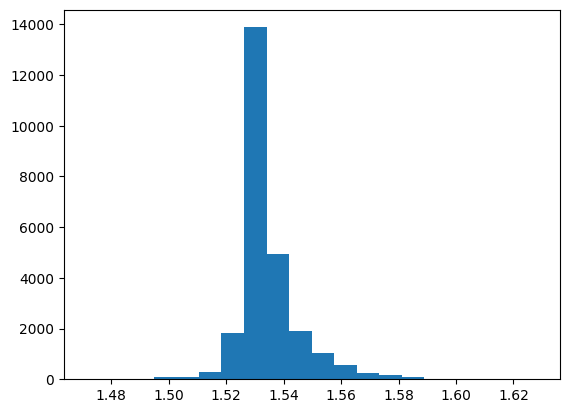

In [24]:
plt.hist(ds, bins=20)
None

In [25]:
np.mean(ds)

1.5346403

## Большинство значений длины между СА-СВ равно 1.53 ангстрем

### Задание 5. Теперь у нас все готово для восстановления атомов $C_\beta$. Загрузите <a href=https://disk.yandex.ru/d/QFymCllkjVpKTg>отсюда</a> подготовленный файл; поместите его в папку с ноутбуком и импортируйте все функции из него:

In [28]:
import sys
sys.path.append('/kaggle/input/ourdata')

In [29]:
from geometry import *

Используйте функцию place_next_dihedral_atom, чтобы получить координаты следующего атома ($D$) в четверке двугранного угла $A,B,C,D$. Интерфейс запуска:
place_next_dihedral_atom(previous_3_atoms, dihedral_angle_val, planar_angle_val, distance), где:

- previous_3_atoms - np.array размера 3x3, где на каждой строчке записаны координаты соответствующего атома ($A,B,C$);
- dihedral_angle_val - значение двугранного угла $\angle (A-B-C-D)$ (в радианах);
- planar_angle_val - значение планарного угла $\angle (B-C-D)$ (в радианах);
- distance - расстояние $C-D$ (в ангстремах).

Пример запуска:

In [30]:
prev_coords = np.array([[0,0,0],
                        [1,0,0],
                        [2,1,0]])
dih_ang_val = np.pi/2
planar_ang_val = np.pi * 3/4
dist = 3
next_at = place_next_dihedral_atom(prev_coords, dih_ang_val, planar_ang_val, dist)
print("Атом D:", next_at)

Атом D: [3.5        2.5        2.12132034]


**Проверка:**

In [31]:
final_dih_ang = pdb.calc_dihedral(pdb.Vector(prev_coords[0]),
                                  pdb.Vector(prev_coords[1]),
                                  pdb.Vector(prev_coords[2]),
                                  pdb.Vector(next_at)
                                 )
print("Получился двугранный угол: {}, а должен быть: {}".format(final_dih_ang, dih_ang_val))

Получился двугранный угол: 1.5707963267948966, а должен быть: 1.5707963267948966


In [32]:
final_plan_ang = pdb.calc_angle(pdb.Vector(prev_coords[1]),
                                pdb.Vector(prev_coords[2]),
                                pdb.Vector(next_at)
                                 )
print("Получился планарный угол: {}, а должен быть: {}".format(final_plan_ang, planar_ang_val))

Получился планарный угол: 2.3561944901923453, а должен быть: 2.356194490192345


In [33]:
final_bond_len = np.linalg.norm(next_at - prev_coords[2])
print("Получилась длина связи: {}, а должна быть: {}".format(final_bond_len, dist))

Получилась длина связи: 3.0000000000000004, а должна быть: 3


### С помощью описанной функции предскажите координаты всех $C_\beta$ в тестовом белке с индексом 0. В отдельную переменную сохраните все настоящие координаты $C_\beta$ из белка.

**Напоминание:** У GLY нет $C_\beta$!

In [34]:
predicted = []

for chain in chains:
    for i in range(1, len(chain)):
        if chain[i].resname=='GLY':
          continue


        c_prev = chain[i-1]['C'].get_vector()
        n = chain[i]['N'].get_vector()
        ca = chain[i]['CA'].get_vector()
        cb = chain[i]['CB'].get_vector()

        value = pdb.calc_dihedral(c_prev, n, ca, cb)

        mean_plannar_ang = np.mean(planar_angls) * np.pi / 180
        mean_d = np.mean(ds)

        prev_cords = [chain[i-1]['C'].get_coord(), chain[i]['N'].get_coord(), chain[i]['CA'].get_coord()]

        x = place_next_dihedral_atom(np.array(prev_cords), value, mean_plannar_ang, mean_d)
        predicted.append(x)


In [35]:
# теперь реальные координаты
orig = []

for chain in chains:
    for i in range(1, len(chain)):
        if chain[i].resname=='GLY':
          continue
        orig.append(chain[i]['CB'].get_coord())

### А теперь давайте посмотрим на точность такого восстановления геометрии. Пусть переменная с предсказанными координатами называется $cb\_pred$, с оригинальными - $cb\_orig$.

In [36]:
from Bio.PDB.qcprot import QCPSuperimposer

In [37]:
imposer = QCPSuperimposer()
imposer.set(np.array(orig), np.array(predicted))
imposer.run()
rms = imposer.get_rms()
print("Точность восстановленных CB = {} ангстрем".format(rms))

Точность восстановленных CB = 0.054194407858646244 ангстрем
